In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

[*********************100%***********************]  5 of 5 completed


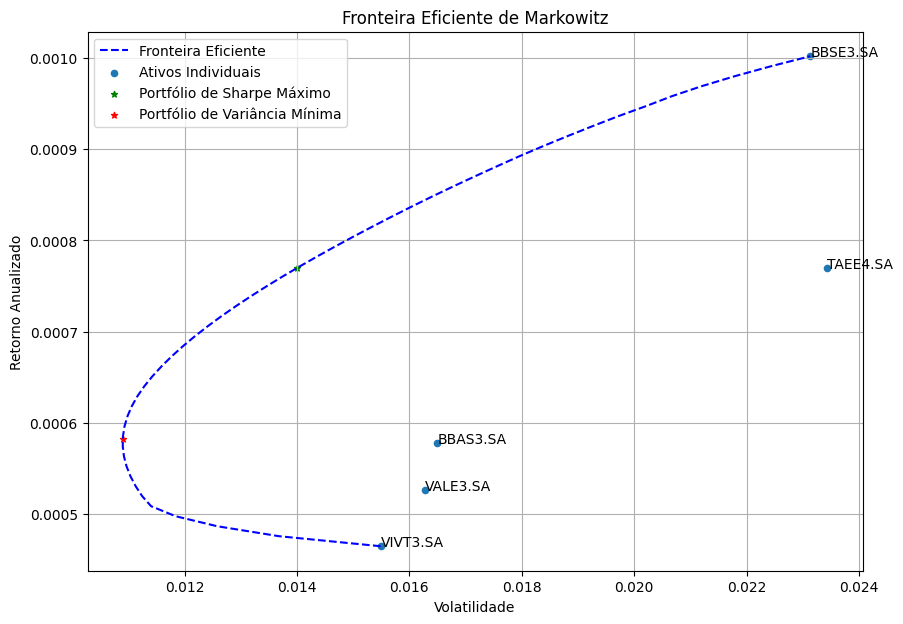


Pesos do Portfólio de Variância Mínima:
TAEE4.SA    0.000000
VALE3.SA    0.237048
VIVT3.SA    0.349041
BBSE3.SA    0.132537
BBAS3.SA    0.281374
dtype: float64

Pesos do Portfólio de Sharpe Máximo:
TAEE4.SA    0.092173
VALE3.SA    0.069222
VIVT3.SA    0.155940
BBSE3.SA    0.461121
BBAS3.SA    0.221545
dtype: float64


In [2]:
# 1. Coleta de Dados Históricos
tickers = ['TAEE4.SA', 'VALE3.SA', 'VIVT3.SA', 'BBSE3.SA', 'BBAS3.SA']
start_date = '2010-01-01'
end_date = '2024-10-31'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 2. Cálculo dos Retornos e Estatísticas
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 3. Funções de Otimização
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# 4. Função para Otimizar Portfólio para Retorno Alvo
def efficient_portfolio(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}
    )
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(minimize_volatility, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# 5. Gerar a Fronteira Eficiente
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_portfolios = []
for target_return in target_returns:
    portfolio = efficient_portfolio(mean_returns, cov_matrix, target_return)
    if portfolio.success:
        returns, std = portfolio_performance(portfolio.x, mean_returns, cov_matrix)
        efficient_portfolios.append({'Retorno': returns, 'Volatilidade': std, 'Pesos': portfolio.x})

# 6. Plotar a Fronteira Eficiente
returns_efficient = [p['Retorno'] for p in efficient_portfolios]
volatilities_efficient = [p['Volatilidade'] for p in efficient_portfolios]

plt.figure(figsize=(10, 7))
plt.plot(volatilities_efficient, returns_efficient, 'b--', label='Fronteira Eficiente')

# Plotar os ativos individuais
plt.scatter(np.sqrt(np.diag(cov_matrix)), mean_returns, marker='o', s=20, label='Ativos Individuais')
for i, txt in enumerate(tickers):
    plt.annotate(txt, (np.sqrt(cov_matrix.iloc[i, i]), mean_returns.iloc[i]))

# 7. Portfólio de Variância Mínima Global
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

min_vol_result = minimize(portfolio_volatility, len(mean_returns) * [1. / len(mean_returns)], args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

min_vol_returns, min_vol_std = portfolio_performance(min_vol_result.x, mean_returns, cov_matrix)

# Identificar o melhor portfólio de Sharpe
sharpe_ratio = (mean_returns - 0.025) / np.sqrt(np.diag(cov_matrix))
max_sharpe = sharpe_ratio.idxmax()
max_sharpe_returns, max_sharpe_std = portfolio_performance(efficient_portfolio(mean_returns, cov_matrix, mean_returns[max_sharpe]).x, mean_returns, cov_matrix)

# sharpe = (mean_returns) / np.sqrt(np.diag(cov_matrix))
# sharpe.index = mean_returns.index  # Certificar-se de que os índices são os tickers
# max_sharpe = sharpe.idxmax()
# max_sharpe_returns = mean_returns[max_sharpe]

# Criar a Series de desvios padrão
# asset_std = pd.Series(np.sqrt(np.diag(cov_matrix)), index=mean_returns.index)
# max_sharpe_std = asset_std[max_sharpe]

# Adicionar o portfólio de sharpe máximo ao gráfico
plt.scatter(max_sharpe_std, max_sharpe_returns, marker='*', color='g', s=20, label='Portfólio de Sharpe Máximo')


# Adicionar o portfólio de variância mínima ao gráfico
plt.scatter(min_vol_std, min_vol_returns, marker='*', color='r', s=20, label='Portfólio de Variância Mínima')

plt.title('Fronteira Eficiente de Markowitz')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Anualizado')
plt.legend()
plt.grid(True)
plt.show()

# 8. Análise dos Pesos dos Portfólios
min_vol_weights = pd.Series(min_vol_result.x, index=tickers)
print("\nPesos do Portfólio de Variância Mínima:")
print(min_vol_weights)

max_sharpe_weights = pd.Series(efficient_portfolio(mean_returns, cov_matrix, max_sharpe_returns).x, index=tickers)
print("\nPesos do Portfólio de Sharpe Máximo:")
print(max_sharpe_weights)